## Using LSTMs to Predict Mid-Price Movement from the Limit Order Book

- The goal of this notebook is to predict whether the mid-price will decrease, stay the same, or increase during the next tick. This is accomplished through the usage of an LSTM in tensorflow.

### Import the necessary packages

In [1]:
%matplotlib inline
from ml_analysis import MLOperator, MLEvaluator, get_LSTM_data
import numpy as np
import pandas as pd
import math
import matplotlib.pyplot as plt
import json
import time
import tensorflow as tf
from tensorflow.contrib import rnn
from sklearn.metrics import f1_score

/Users/macbook/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


### Prepare the data

In [2]:
df = pd.read_csv('all_features_new_intc_1s_hrzn.csv')
df = df.dropna()
train_weight = 0.8
split = int(len(df)*train_weight)
df_train = df[:split]
df_test = df[split:]
operator = MLOperator()
n_steps = 5
use_features = list(df.columns[:-1])
y_train = df_train.label
sampled_idx = operator.get_samples_index(y_train.iloc[n_steps-1:], 'min')
x_train = df_train[use_features]
y_test = df_test.label.iloc[n_steps-1:]
x_test = df_test[use_features]
x_train, y_train, x_test, y_test = get_LSTM_data(x_train, y_train, x_test, y_test, sampled_idx, n_steps)
#normalization
x_max = np.max(x_train,axis=0)
x_min = np.min(x_train,axis=0)
x_train = (x_train - x_min) / (x_max - x_min)
x_test = (x_test - x_min) / (x_max - x_min)
nrow = 3000
x_valid = x_test[0:nrow]
y_valid = y_test[0:nrow]
x_test = x_test[nrow:]
y_test = y_test[nrow:]
print (x_train.shape,y_train.shape,x_test.shape,y_test.shape, x_valid.shape, y_valid.shape)

(154260, 5, 64) (154260, 3) (101761, 5, 64) (101761, 3) (3000, 5, 64) (3000, 3)


In [3]:
df.label.value_counts()

 0    372834
-1     85613
 1     65377
Name: label, dtype: int64

### Set the parameters

In [4]:
# Training Parameters
learning_rate = 0.0001
n_epoch = 2000
n_batch = 500
display_step = 1

# Network Parameters
num_input = x_train.shape[-1] # number of features
timesteps = n_steps # timesteps
num_hidden = 7 # hidden layer num of features
num_classes = 3 # up, down and no-movement

# tf Graph input
# the input variables are first define as placeholder
# a placeholder is a variable/data which will be assigned later
X = tf.placeholder("float", [None, timesteps, num_input]) #dim: batch_size, number of time steps, number of inputs
Y = tf.placeholder("float", [None, num_classes])#dim:batch_size, number of classes (10 here)

#initialize the weigths with a normal random law initialization

weights = {
    'out': tf.Variable(tf.random_normal([num_hidden, num_classes]))
}
biases = {
    'out': tf.Variable(tf.random_normal([num_classes]))
}

### Define the RNN

In [5]:
def RNN(x, weights, biases):
    # Unstack to get a list of 'timesteps' tensors of shape (batch_size, n_input)
    x = tf.unstack(x, timesteps, 1)

    # 1-layer LSTM with num_hidden units
    #rnn_cell = rnn.BasicLSTMCell(num_hidden,activation=tf.nn.sigmoid)
    rnn_cell = rnn.BasicLSTMCell(num_hidden)

    
    # 2-layer LSTM, each layer has num_hidden units. And you can wrap more layers together by doing list comprehension.
    #rnn_cell = rnn.MultiRNNCell([rnn.BasicLSTMCell(num_hidden),rnn.BasicLSTMCell(num_hidden)])

    # Get rnn cell output
    outputs, states = rnn.static_rnn(rnn_cell, x, dtype=tf.float32)

    # (1) Linear activation, using rnn inner loop last output
    return tf.matmul(outputs[-1], weights['out']) + biases['out']


### Define the loss and optimzation

In [6]:
logits = RNN(X, weights, biases)
prediction = tf.nn.softmax(logits)
#define the loss 
loss_op = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(
    logits=logits, labels=Y))
#optimizer = tf.train.GradientDescentOptimizer(learning_rate=learning_rate)
optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate)
train_op = optimizer.minimize(loss_op)
#tf.equal: Returns the truth value of (x == y) element-wise.
#tf.cast: Casts a tensor to a new type. --- here it casts from boolean to float
#tf.argmax:Returns the index with the largest value across axes of a tensor. --- here along the axis of the vector

correct_pred = tf.equal(tf.argmax(prediction, 1), tf.argmax(Y, 1))
accuracy = tf.reduce_mean(tf.cast(correct_pred, tf.float32))
init = tf.global_variables_initializer()

Instructions for updating:

Future major versions of TensorFlow will allow gradients to flow
into the labels input on backprop by default.

See @{tf.nn.softmax_cross_entropy_with_logits_v2}.



### Run the model

In [7]:
# Start training
with tf.Session() as sess:
    
    start_time = time.time()
    
    #please, make sure you changed for your own path 
    #log_files_path = '/Users/macbook/Desktop/DLFall2018/codes/DL project/tensorflow-master/logs'
    log_files_path = '/Users/macbook/Desktop/DLFall2018/codes/DL project/tensorflow-master/logs'
    
    #save and restore variables to and from checkpoints.
    saver = tf.train.Saver()

    # Run the initializer
    sess.run(init)
    
    #will work with this later
    #saver.restore(sess, log_files_path+'multi_layer/model-checkpoint-66000')
    
    loss_trace = []
    
    num_examples = x_train.shape[0]

    # Training cycle
    for epoch in range(n_epoch):
        
        avg_cost = 0.
        total_batch = int(num_examples/n_batch)
        
        # Shuffle the data
        perm = np.arange(num_examples)
        np.random.shuffle(perm)
        x_train = x_train[perm]
        y_train = y_train[perm]
                    
        # Loop over all batches
        for i in range(total_batch):
            
            minibatch_x, minibatch_y = x_train[i*n_batch:(i+1)*n_batch], y_train[i*n_batch:(i+1)*n_batch]

            #minibatch_x, minibatch_y = mnist.train.next_batch(batch_size)
            
            # Fit training using batch data
            #the training is done using the training dataset
            sess.run(train_op, feed_dict={X: minibatch_x, Y: minibatch_y})
            # Compute average loss
            avg_cost += sess.run(loss_op, feed_dict={X: minibatch_x, Y: minibatch_y})/total_batch
        
        # Display logs per epoch step
        if epoch % display_step == 0:
                    
            #the accuracy is evaluated using the validation dataset
            train_acc = sess.run(accuracy, feed_dict={X: x_train, Y: y_train})
            val_cost = sess.run(loss_op, feed_dict={X: x_valid, Y: y_valid})
            acc = sess.run(accuracy, feed_dict={X: x_valid, Y: y_valid})
            loss_trace.append(1-acc)    
            print("Epoch:", '%04d' % (epoch+1), "train_loss :", "{:0.4f}".format(avg_cost), "train_acc :", "{:0.4f}".format(train_acc), \
                  "val_loss :", "{:0.4f}".format(val_cost), "val_acc :", "{:0.4f}".format(acc))    
    
    #save to use later
    saver.save(sess, log_files_path)
    
    print("Optimization Finished!")
    #accuracy evaluated with the whole test dataset
    acc = sess.run(accuracy, feed_dict={X: x_test, Y: y_test})
    print("Test Accuracy:", acc)
                    
    elapsed_time = time.time() - start_time
    print('Execution time (seconds) was %0.3f' % elapsed_time)

Epoch: 0001 train_loss : 1.3042 train_acc : 0.4128 val_loss : 0.9238 val_acc : 0.6680
Epoch: 0002 train_loss : 1.0606 train_acc : 0.5122 val_loss : 0.9270 val_acc : 0.6740
Epoch: 0003 train_loss : 0.9846 train_acc : 0.5761 val_loss : 0.8725 val_acc : 0.6650
Epoch: 0004 train_loss : 0.9132 train_acc : 0.6130 val_loss : 0.7839 val_acc : 0.7093
Epoch: 0005 train_loss : 0.8500 train_acc : 0.6412 val_loss : 0.6960 val_acc : 0.7377
Epoch: 0006 train_loss : 0.7993 train_acc : 0.6601 val_loss : 0.6244 val_acc : 0.7810
Epoch: 0007 train_loss : 0.7657 train_acc : 0.6735 val_loss : 0.5590 val_acc : 0.8340
Epoch: 0008 train_loss : 0.7421 train_acc : 0.6837 val_loss : 0.5004 val_acc : 0.8813
Epoch: 0009 train_loss : 0.7255 train_acc : 0.6918 val_loss : 0.4584 val_acc : 0.9083
Epoch: 0010 train_loss : 0.7129 train_acc : 0.6980 val_loss : 0.4203 val_acc : 0.9257
Epoch: 0011 train_loss : 0.7031 train_acc : 0.7042 val_loss : 0.3962 val_acc : 0.9257
Epoch: 0012 train_loss : 0.6954 train_acc : 0.7088 val

Epoch: 0097 train_loss : 0.5967 train_acc : 0.7489 val_loss : 0.2381 val_acc : 0.9320
Epoch: 0098 train_loss : 0.5962 train_acc : 0.7489 val_loss : 0.2389 val_acc : 0.9300
Epoch: 0099 train_loss : 0.5957 train_acc : 0.7486 val_loss : 0.2435 val_acc : 0.9273
Epoch: 0100 train_loss : 0.5954 train_acc : 0.7492 val_loss : 0.2435 val_acc : 0.9260
Epoch: 0101 train_loss : 0.5947 train_acc : 0.7487 val_loss : 0.2426 val_acc : 0.9280
Epoch: 0102 train_loss : 0.5943 train_acc : 0.7500 val_loss : 0.2349 val_acc : 0.9287
Epoch: 0103 train_loss : 0.5940 train_acc : 0.7504 val_loss : 0.2367 val_acc : 0.9290
Epoch: 0104 train_loss : 0.5934 train_acc : 0.7488 val_loss : 0.2462 val_acc : 0.9253
Epoch: 0105 train_loss : 0.5930 train_acc : 0.7505 val_loss : 0.2398 val_acc : 0.9273
Epoch: 0106 train_loss : 0.5927 train_acc : 0.7501 val_loss : 0.2418 val_acc : 0.9247
Epoch: 0107 train_loss : 0.5921 train_acc : 0.7508 val_loss : 0.2442 val_acc : 0.9257
Epoch: 0108 train_loss : 0.5918 train_acc : 0.7511 val

Epoch: 0193 train_loss : 0.5666 train_acc : 0.7617 val_loss : 0.2328 val_acc : 0.9187
Epoch: 0194 train_loss : 0.5663 train_acc : 0.7625 val_loss : 0.2280 val_acc : 0.9197
Epoch: 0195 train_loss : 0.5662 train_acc : 0.7628 val_loss : 0.2340 val_acc : 0.9170
Epoch: 0196 train_loss : 0.5660 train_acc : 0.7622 val_loss : 0.2354 val_acc : 0.9170
Epoch: 0197 train_loss : 0.5658 train_acc : 0.7628 val_loss : 0.2310 val_acc : 0.9180
Epoch: 0198 train_loss : 0.5653 train_acc : 0.7631 val_loss : 0.2283 val_acc : 0.9193
Epoch: 0199 train_loss : 0.5651 train_acc : 0.7629 val_loss : 0.2370 val_acc : 0.9160
Epoch: 0200 train_loss : 0.5649 train_acc : 0.7631 val_loss : 0.2392 val_acc : 0.9153
Epoch: 0201 train_loss : 0.5647 train_acc : 0.7633 val_loss : 0.2324 val_acc : 0.9170
Epoch: 0202 train_loss : 0.5644 train_acc : 0.7634 val_loss : 0.2308 val_acc : 0.9180
Epoch: 0203 train_loss : 0.5644 train_acc : 0.7632 val_loss : 0.2288 val_acc : 0.9190
Epoch: 0204 train_loss : 0.5643 train_acc : 0.7632 val

Epoch: 0289 train_loss : 0.5470 train_acc : 0.7709 val_loss : 0.2339 val_acc : 0.9250
Epoch: 0290 train_loss : 0.5472 train_acc : 0.7712 val_loss : 0.2330 val_acc : 0.9250
Epoch: 0291 train_loss : 0.5470 train_acc : 0.7709 val_loss : 0.2320 val_acc : 0.9240
Epoch: 0292 train_loss : 0.5470 train_acc : 0.7712 val_loss : 0.2274 val_acc : 0.9263
Epoch: 0293 train_loss : 0.5468 train_acc : 0.7713 val_loss : 0.2230 val_acc : 0.9277
Epoch: 0294 train_loss : 0.5464 train_acc : 0.7716 val_loss : 0.2295 val_acc : 0.9250
Epoch: 0295 train_loss : 0.5462 train_acc : 0.7712 val_loss : 0.2363 val_acc : 0.9237
Epoch: 0296 train_loss : 0.5461 train_acc : 0.7716 val_loss : 0.2354 val_acc : 0.9247
Epoch: 0297 train_loss : 0.5456 train_acc : 0.7721 val_loss : 0.2287 val_acc : 0.9250
Epoch: 0298 train_loss : 0.5457 train_acc : 0.7694 val_loss : 0.2256 val_acc : 0.9270
Epoch: 0299 train_loss : 0.5456 train_acc : 0.7719 val_loss : 0.2278 val_acc : 0.9267
Epoch: 0300 train_loss : 0.5453 train_acc : 0.7723 val

Epoch: 0385 train_loss : 0.5329 train_acc : 0.7778 val_loss : 0.2327 val_acc : 0.9257
Epoch: 0386 train_loss : 0.5329 train_acc : 0.7761 val_loss : 0.2213 val_acc : 0.9370
Epoch: 0387 train_loss : 0.5327 train_acc : 0.7777 val_loss : 0.2291 val_acc : 0.9247
Epoch: 0388 train_loss : 0.5327 train_acc : 0.7769 val_loss : 0.2274 val_acc : 0.9290
Epoch: 0389 train_loss : 0.5325 train_acc : 0.7773 val_loss : 0.2226 val_acc : 0.9297
Epoch: 0390 train_loss : 0.5325 train_acc : 0.7777 val_loss : 0.2288 val_acc : 0.9270
Epoch: 0391 train_loss : 0.5323 train_acc : 0.7779 val_loss : 0.2322 val_acc : 0.9250
Epoch: 0392 train_loss : 0.5321 train_acc : 0.7763 val_loss : 0.2348 val_acc : 0.9273
Epoch: 0393 train_loss : 0.5322 train_acc : 0.7783 val_loss : 0.2224 val_acc : 0.9333
Epoch: 0394 train_loss : 0.5319 train_acc : 0.7776 val_loss : 0.2308 val_acc : 0.9270
Epoch: 0395 train_loss : 0.5319 train_acc : 0.7773 val_loss : 0.2223 val_acc : 0.9260
Epoch: 0396 train_loss : 0.5318 train_acc : 0.7778 val

Epoch: 0481 train_loss : 0.5224 train_acc : 0.7812 val_loss : 0.2311 val_acc : 0.9283
Epoch: 0482 train_loss : 0.5221 train_acc : 0.7815 val_loss : 0.2327 val_acc : 0.9287
Epoch: 0483 train_loss : 0.5223 train_acc : 0.7821 val_loss : 0.2250 val_acc : 0.9323
Epoch: 0484 train_loss : 0.5222 train_acc : 0.7822 val_loss : 0.2248 val_acc : 0.9337
Epoch: 0485 train_loss : 0.5218 train_acc : 0.7825 val_loss : 0.2303 val_acc : 0.9253
Epoch: 0486 train_loss : 0.5221 train_acc : 0.7809 val_loss : 0.2278 val_acc : 0.9300
Epoch: 0487 train_loss : 0.5216 train_acc : 0.7822 val_loss : 0.2193 val_acc : 0.9367
Epoch: 0488 train_loss : 0.5217 train_acc : 0.7821 val_loss : 0.2232 val_acc : 0.9347
Epoch: 0489 train_loss : 0.5217 train_acc : 0.7809 val_loss : 0.2262 val_acc : 0.9343
Epoch: 0490 train_loss : 0.5215 train_acc : 0.7815 val_loss : 0.2256 val_acc : 0.9340
Epoch: 0491 train_loss : 0.5214 train_acc : 0.7824 val_loss : 0.2419 val_acc : 0.9223
Epoch: 0492 train_loss : 0.5212 train_acc : 0.7823 val

Epoch: 0577 train_loss : 0.5138 train_acc : 0.7851 val_loss : 0.2377 val_acc : 0.9253
Epoch: 0578 train_loss : 0.5137 train_acc : 0.7843 val_loss : 0.2396 val_acc : 0.9243
Epoch: 0579 train_loss : 0.5137 train_acc : 0.7854 val_loss : 0.2354 val_acc : 0.9250
Epoch: 0580 train_loss : 0.5138 train_acc : 0.7838 val_loss : 0.2393 val_acc : 0.9230
Epoch: 0581 train_loss : 0.5136 train_acc : 0.7855 val_loss : 0.2351 val_acc : 0.9253
Epoch: 0582 train_loss : 0.5134 train_acc : 0.7855 val_loss : 0.2313 val_acc : 0.9260
Epoch: 0583 train_loss : 0.5131 train_acc : 0.7857 val_loss : 0.2326 val_acc : 0.9257
Epoch: 0584 train_loss : 0.5133 train_acc : 0.7854 val_loss : 0.2338 val_acc : 0.9250
Epoch: 0585 train_loss : 0.5131 train_acc : 0.7853 val_loss : 0.2306 val_acc : 0.9257
Epoch: 0586 train_loss : 0.5132 train_acc : 0.7857 val_loss : 0.2338 val_acc : 0.9243
Epoch: 0587 train_loss : 0.5129 train_acc : 0.7860 val_loss : 0.2304 val_acc : 0.9260
Epoch: 0588 train_loss : 0.5128 train_acc : 0.7857 val

Epoch: 0673 train_loss : 0.5063 train_acc : 0.7882 val_loss : 0.2413 val_acc : 0.9223
Epoch: 0674 train_loss : 0.5067 train_acc : 0.7885 val_loss : 0.2495 val_acc : 0.9177
Epoch: 0675 train_loss : 0.5063 train_acc : 0.7883 val_loss : 0.2490 val_acc : 0.9180
Epoch: 0676 train_loss : 0.5063 train_acc : 0.7885 val_loss : 0.2459 val_acc : 0.9187
Epoch: 0677 train_loss : 0.5064 train_acc : 0.7884 val_loss : 0.2391 val_acc : 0.9230
Epoch: 0678 train_loss : 0.5063 train_acc : 0.7883 val_loss : 0.2498 val_acc : 0.9190
Epoch: 0679 train_loss : 0.5062 train_acc : 0.7887 val_loss : 0.2404 val_acc : 0.9240
Epoch: 0680 train_loss : 0.5062 train_acc : 0.7884 val_loss : 0.2450 val_acc : 0.9193
Epoch: 0681 train_loss : 0.5064 train_acc : 0.7884 val_loss : 0.2318 val_acc : 0.9270
Epoch: 0682 train_loss : 0.5059 train_acc : 0.7888 val_loss : 0.2461 val_acc : 0.9190
Epoch: 0683 train_loss : 0.5056 train_acc : 0.7889 val_loss : 0.2429 val_acc : 0.9207
Epoch: 0684 train_loss : 0.5060 train_acc : 0.7885 val

Epoch: 0769 train_loss : 0.5002 train_acc : 0.7914 val_loss : 0.2643 val_acc : 0.9100
Epoch: 0770 train_loss : 0.5001 train_acc : 0.7914 val_loss : 0.2524 val_acc : 0.9177
Epoch: 0771 train_loss : 0.4997 train_acc : 0.7913 val_loss : 0.2570 val_acc : 0.9140
Epoch: 0772 train_loss : 0.4997 train_acc : 0.7907 val_loss : 0.2478 val_acc : 0.9183
Epoch: 0773 train_loss : 0.4996 train_acc : 0.7913 val_loss : 0.2493 val_acc : 0.9183
Epoch: 0774 train_loss : 0.5000 train_acc : 0.7913 val_loss : 0.2455 val_acc : 0.9190
Epoch: 0775 train_loss : 0.5000 train_acc : 0.7914 val_loss : 0.2470 val_acc : 0.9187
Epoch: 0776 train_loss : 0.4996 train_acc : 0.7917 val_loss : 0.2524 val_acc : 0.9153
Epoch: 0777 train_loss : 0.4997 train_acc : 0.7912 val_loss : 0.2546 val_acc : 0.9150
Epoch: 0778 train_loss : 0.4994 train_acc : 0.7912 val_loss : 0.2494 val_acc : 0.9187
Epoch: 0779 train_loss : 0.4995 train_acc : 0.7914 val_loss : 0.2604 val_acc : 0.9127
Epoch: 0780 train_loss : 0.4994 train_acc : 0.7911 val

Epoch: 0865 train_loss : 0.4943 train_acc : 0.7930 val_loss : 0.2571 val_acc : 0.9097
Epoch: 0866 train_loss : 0.4942 train_acc : 0.7937 val_loss : 0.2489 val_acc : 0.9157
Epoch: 0867 train_loss : 0.4943 train_acc : 0.7935 val_loss : 0.2486 val_acc : 0.9173
Epoch: 0868 train_loss : 0.4940 train_acc : 0.7940 val_loss : 0.2604 val_acc : 0.9100
Epoch: 0869 train_loss : 0.4942 train_acc : 0.7939 val_loss : 0.2576 val_acc : 0.9130
Epoch: 0870 train_loss : 0.4941 train_acc : 0.7934 val_loss : 0.2526 val_acc : 0.9143
Epoch: 0871 train_loss : 0.4938 train_acc : 0.7944 val_loss : 0.2577 val_acc : 0.9143
Epoch: 0872 train_loss : 0.4938 train_acc : 0.7945 val_loss : 0.2616 val_acc : 0.9123
Epoch: 0873 train_loss : 0.4938 train_acc : 0.7945 val_loss : 0.2619 val_acc : 0.9110
Epoch: 0874 train_loss : 0.4937 train_acc : 0.7935 val_loss : 0.2487 val_acc : 0.9183
Epoch: 0875 train_loss : 0.4934 train_acc : 0.7926 val_loss : 0.2541 val_acc : 0.9137
Epoch: 0876 train_loss : 0.4936 train_acc : 0.7933 val

Epoch: 0961 train_loss : 0.4888 train_acc : 0.7960 val_loss : 0.2767 val_acc : 0.9033
Epoch: 0962 train_loss : 0.4892 train_acc : 0.7968 val_loss : 0.2708 val_acc : 0.9053
Epoch: 0963 train_loss : 0.4888 train_acc : 0.7965 val_loss : 0.2714 val_acc : 0.9050
Epoch: 0964 train_loss : 0.4884 train_acc : 0.7973 val_loss : 0.2615 val_acc : 0.9097
Epoch: 0965 train_loss : 0.4884 train_acc : 0.7958 val_loss : 0.2653 val_acc : 0.9080
Epoch: 0966 train_loss : 0.4885 train_acc : 0.7965 val_loss : 0.2653 val_acc : 0.9090
Epoch: 0967 train_loss : 0.4883 train_acc : 0.7972 val_loss : 0.2606 val_acc : 0.9093
Epoch: 0968 train_loss : 0.4885 train_acc : 0.7968 val_loss : 0.2696 val_acc : 0.9067
Epoch: 0969 train_loss : 0.4883 train_acc : 0.7971 val_loss : 0.2639 val_acc : 0.9080
Epoch: 0970 train_loss : 0.4884 train_acc : 0.7970 val_loss : 0.2658 val_acc : 0.9080
Epoch: 0971 train_loss : 0.4883 train_acc : 0.7967 val_loss : 0.2777 val_acc : 0.9037
Epoch: 0972 train_loss : 0.4882 train_acc : 0.7965 val

Epoch: 1057 train_loss : 0.4839 train_acc : 0.7992 val_loss : 0.2563 val_acc : 0.9123
Epoch: 1058 train_loss : 0.4837 train_acc : 0.7994 val_loss : 0.2681 val_acc : 0.9060
Epoch: 1059 train_loss : 0.4837 train_acc : 0.7996 val_loss : 0.2808 val_acc : 0.9017
Epoch: 1060 train_loss : 0.4839 train_acc : 0.7993 val_loss : 0.2722 val_acc : 0.9057
Epoch: 1061 train_loss : 0.4836 train_acc : 0.7998 val_loss : 0.2755 val_acc : 0.9040
Epoch: 1062 train_loss : 0.4837 train_acc : 0.7989 val_loss : 0.2899 val_acc : 0.8970
Epoch: 1063 train_loss : 0.4841 train_acc : 0.7996 val_loss : 0.2833 val_acc : 0.9010
Epoch: 1064 train_loss : 0.4834 train_acc : 0.7993 val_loss : 0.2780 val_acc : 0.9033
Epoch: 1065 train_loss : 0.4836 train_acc : 0.7989 val_loss : 0.2694 val_acc : 0.9063
Epoch: 1066 train_loss : 0.4835 train_acc : 0.7998 val_loss : 0.2872 val_acc : 0.8993
Epoch: 1067 train_loss : 0.4833 train_acc : 0.7992 val_loss : 0.2817 val_acc : 0.9003
Epoch: 1068 train_loss : 0.4832 train_acc : 0.7988 val

Epoch: 1153 train_loss : 0.4791 train_acc : 0.8021 val_loss : 0.2879 val_acc : 0.8980
Epoch: 1154 train_loss : 0.4790 train_acc : 0.8017 val_loss : 0.2888 val_acc : 0.8977
Epoch: 1155 train_loss : 0.4792 train_acc : 0.8020 val_loss : 0.2759 val_acc : 0.9047
Epoch: 1156 train_loss : 0.4793 train_acc : 0.8016 val_loss : 0.2685 val_acc : 0.9087
Epoch: 1157 train_loss : 0.4791 train_acc : 0.8024 val_loss : 0.2815 val_acc : 0.9003
Epoch: 1158 train_loss : 0.4794 train_acc : 0.8008 val_loss : 0.2877 val_acc : 0.8970
Epoch: 1159 train_loss : 0.4791 train_acc : 0.8019 val_loss : 0.2650 val_acc : 0.9097
Epoch: 1160 train_loss : 0.4789 train_acc : 0.8024 val_loss : 0.2938 val_acc : 0.8957
Epoch: 1161 train_loss : 0.4788 train_acc : 0.8023 val_loss : 0.2743 val_acc : 0.9047
Epoch: 1162 train_loss : 0.4786 train_acc : 0.8024 val_loss : 0.2861 val_acc : 0.8990
Epoch: 1163 train_loss : 0.4784 train_acc : 0.8015 val_loss : 0.2768 val_acc : 0.9037
Epoch: 1164 train_loss : 0.4791 train_acc : 0.8025 val

Epoch: 1249 train_loss : 0.4748 train_acc : 0.8041 val_loss : 0.2820 val_acc : 0.9037
Epoch: 1250 train_loss : 0.4750 train_acc : 0.8044 val_loss : 0.2788 val_acc : 0.9030
Epoch: 1251 train_loss : 0.4747 train_acc : 0.8047 val_loss : 0.2867 val_acc : 0.8980
Epoch: 1252 train_loss : 0.4746 train_acc : 0.8035 val_loss : 0.2918 val_acc : 0.8987
Epoch: 1253 train_loss : 0.4748 train_acc : 0.8033 val_loss : 0.2906 val_acc : 0.8963
Epoch: 1254 train_loss : 0.4747 train_acc : 0.8039 val_loss : 0.2793 val_acc : 0.9040
Epoch: 1255 train_loss : 0.4749 train_acc : 0.8043 val_loss : 0.3015 val_acc : 0.8897
Epoch: 1256 train_loss : 0.4749 train_acc : 0.8030 val_loss : 0.2786 val_acc : 0.9033
Epoch: 1257 train_loss : 0.4746 train_acc : 0.8045 val_loss : 0.2833 val_acc : 0.8997
Epoch: 1258 train_loss : 0.4746 train_acc : 0.8038 val_loss : 0.2702 val_acc : 0.9070
Epoch: 1259 train_loss : 0.4747 train_acc : 0.8048 val_loss : 0.2906 val_acc : 0.8953
Epoch: 1260 train_loss : 0.4745 train_acc : 0.8044 val

Epoch: 1345 train_loss : 0.4711 train_acc : 0.8055 val_loss : 0.2835 val_acc : 0.9013
Epoch: 1346 train_loss : 0.4712 train_acc : 0.8041 val_loss : 0.2840 val_acc : 0.9030
Epoch: 1347 train_loss : 0.4710 train_acc : 0.8061 val_loss : 0.2876 val_acc : 0.8983
Epoch: 1348 train_loss : 0.4714 train_acc : 0.8062 val_loss : 0.3058 val_acc : 0.8887
Epoch: 1349 train_loss : 0.4709 train_acc : 0.8042 val_loss : 0.2751 val_acc : 0.9067
Epoch: 1350 train_loss : 0.4707 train_acc : 0.8056 val_loss : 0.3002 val_acc : 0.8900
Epoch: 1351 train_loss : 0.4709 train_acc : 0.8061 val_loss : 0.2929 val_acc : 0.8957
Epoch: 1352 train_loss : 0.4706 train_acc : 0.8055 val_loss : 0.2873 val_acc : 0.8980
Epoch: 1353 train_loss : 0.4707 train_acc : 0.8061 val_loss : 0.2865 val_acc : 0.8990
Epoch: 1354 train_loss : 0.4708 train_acc : 0.8058 val_loss : 0.2947 val_acc : 0.8933
Epoch: 1355 train_loss : 0.4708 train_acc : 0.8060 val_loss : 0.2944 val_acc : 0.8943
Epoch: 1356 train_loss : 0.4707 train_acc : 0.8065 val

Epoch: 1441 train_loss : 0.4675 train_acc : 0.8075 val_loss : 0.2907 val_acc : 0.8967
Epoch: 1442 train_loss : 0.4674 train_acc : 0.8074 val_loss : 0.2810 val_acc : 0.9040
Epoch: 1443 train_loss : 0.4673 train_acc : 0.8070 val_loss : 0.2828 val_acc : 0.9023
Epoch: 1444 train_loss : 0.4672 train_acc : 0.8072 val_loss : 0.2892 val_acc : 0.8990
Epoch: 1445 train_loss : 0.4671 train_acc : 0.8071 val_loss : 0.3233 val_acc : 0.8783
Epoch: 1446 train_loss : 0.4672 train_acc : 0.8078 val_loss : 0.2896 val_acc : 0.8987
Epoch: 1447 train_loss : 0.4673 train_acc : 0.8080 val_loss : 0.2851 val_acc : 0.9023
Epoch: 1448 train_loss : 0.4673 train_acc : 0.8072 val_loss : 0.3004 val_acc : 0.8913
Epoch: 1449 train_loss : 0.4671 train_acc : 0.8076 val_loss : 0.2870 val_acc : 0.9010
Epoch: 1450 train_loss : 0.4672 train_acc : 0.8077 val_loss : 0.3012 val_acc : 0.8913
Epoch: 1451 train_loss : 0.4670 train_acc : 0.8078 val_loss : 0.3058 val_acc : 0.8893
Epoch: 1452 train_loss : 0.4669 train_acc : 0.8077 val

Epoch: 1537 train_loss : 0.4643 train_acc : 0.8091 val_loss : 0.3162 val_acc : 0.8823
Epoch: 1538 train_loss : 0.4642 train_acc : 0.8083 val_loss : 0.2794 val_acc : 0.9017
Epoch: 1539 train_loss : 0.4640 train_acc : 0.8089 val_loss : 0.2879 val_acc : 0.8983
Epoch: 1540 train_loss : 0.4638 train_acc : 0.8089 val_loss : 0.3104 val_acc : 0.8873
Epoch: 1541 train_loss : 0.4638 train_acc : 0.8091 val_loss : 0.2919 val_acc : 0.8977
Epoch: 1542 train_loss : 0.4639 train_acc : 0.8094 val_loss : 0.3144 val_acc : 0.8837
Epoch: 1543 train_loss : 0.4638 train_acc : 0.8092 val_loss : 0.3066 val_acc : 0.8860
Epoch: 1544 train_loss : 0.4637 train_acc : 0.8092 val_loss : 0.3072 val_acc : 0.8867
Epoch: 1545 train_loss : 0.4636 train_acc : 0.8087 val_loss : 0.2987 val_acc : 0.8927
Epoch: 1546 train_loss : 0.4637 train_acc : 0.8073 val_loss : 0.2757 val_acc : 0.9033
Epoch: 1547 train_loss : 0.4638 train_acc : 0.8089 val_loss : 0.3039 val_acc : 0.8880
Epoch: 1548 train_loss : 0.4637 train_acc : 0.8090 val

Epoch: 1633 train_loss : 0.4609 train_acc : 0.8106 val_loss : 0.2979 val_acc : 0.8927
Epoch: 1634 train_loss : 0.4608 train_acc : 0.8102 val_loss : 0.3121 val_acc : 0.8827
Epoch: 1635 train_loss : 0.4606 train_acc : 0.8107 val_loss : 0.3007 val_acc : 0.8923
Epoch: 1636 train_loss : 0.4608 train_acc : 0.8101 val_loss : 0.2932 val_acc : 0.8950
Epoch: 1637 train_loss : 0.4606 train_acc : 0.8106 val_loss : 0.2998 val_acc : 0.8900
Epoch: 1638 train_loss : 0.4606 train_acc : 0.8110 val_loss : 0.2927 val_acc : 0.8943
Epoch: 1639 train_loss : 0.4606 train_acc : 0.8102 val_loss : 0.2962 val_acc : 0.8923
Epoch: 1640 train_loss : 0.4606 train_acc : 0.8105 val_loss : 0.2897 val_acc : 0.8967
Epoch: 1641 train_loss : 0.4605 train_acc : 0.8095 val_loss : 0.3019 val_acc : 0.8860
Epoch: 1642 train_loss : 0.4606 train_acc : 0.8100 val_loss : 0.3027 val_acc : 0.8873
Epoch: 1643 train_loss : 0.4610 train_acc : 0.8103 val_loss : 0.2940 val_acc : 0.8927
Epoch: 1644 train_loss : 0.4604 train_acc : 0.8111 val

Epoch: 1729 train_loss : 0.4577 train_acc : 0.8113 val_loss : 0.2933 val_acc : 0.8917
Epoch: 1730 train_loss : 0.4578 train_acc : 0.8104 val_loss : 0.3078 val_acc : 0.8863
Epoch: 1731 train_loss : 0.4581 train_acc : 0.8113 val_loss : 0.3014 val_acc : 0.8870
Epoch: 1732 train_loss : 0.4574 train_acc : 0.8106 val_loss : 0.3164 val_acc : 0.8777
Epoch: 1733 train_loss : 0.4580 train_acc : 0.8101 val_loss : 0.3218 val_acc : 0.8767
Epoch: 1734 train_loss : 0.4574 train_acc : 0.8110 val_loss : 0.3067 val_acc : 0.8853
Epoch: 1735 train_loss : 0.4577 train_acc : 0.8119 val_loss : 0.3020 val_acc : 0.8860
Epoch: 1736 train_loss : 0.4576 train_acc : 0.8114 val_loss : 0.3131 val_acc : 0.8810
Epoch: 1737 train_loss : 0.4577 train_acc : 0.8112 val_loss : 0.2959 val_acc : 0.8880
Epoch: 1738 train_loss : 0.4572 train_acc : 0.8121 val_loss : 0.3125 val_acc : 0.8810
Epoch: 1739 train_loss : 0.4573 train_acc : 0.8117 val_loss : 0.3059 val_acc : 0.8847
Epoch: 1740 train_loss : 0.4576 train_acc : 0.8116 val

Epoch: 1825 train_loss : 0.4549 train_acc : 0.8136 val_loss : 0.3108 val_acc : 0.8790
Epoch: 1826 train_loss : 0.4548 train_acc : 0.8122 val_loss : 0.2880 val_acc : 0.8867
Epoch: 1827 train_loss : 0.4552 train_acc : 0.8125 val_loss : 0.3015 val_acc : 0.8830
Epoch: 1828 train_loss : 0.4547 train_acc : 0.8107 val_loss : 0.3089 val_acc : 0.8797
Epoch: 1829 train_loss : 0.4546 train_acc : 0.8132 val_loss : 0.3023 val_acc : 0.8833
Epoch: 1830 train_loss : 0.4545 train_acc : 0.8128 val_loss : 0.3074 val_acc : 0.8800
Epoch: 1831 train_loss : 0.4545 train_acc : 0.8133 val_loss : 0.3181 val_acc : 0.8767
Epoch: 1832 train_loss : 0.4544 train_acc : 0.8138 val_loss : 0.3005 val_acc : 0.8827
Epoch: 1833 train_loss : 0.4547 train_acc : 0.8133 val_loss : 0.3094 val_acc : 0.8787
Epoch: 1834 train_loss : 0.4543 train_acc : 0.8100 val_loss : 0.2959 val_acc : 0.8857
Epoch: 1835 train_loss : 0.4545 train_acc : 0.8134 val_loss : 0.3063 val_acc : 0.8793
Epoch: 1836 train_loss : 0.4543 train_acc : 0.8129 val

Epoch: 1921 train_loss : 0.4520 train_acc : 0.8145 val_loss : 0.2904 val_acc : 0.8827
Epoch: 1922 train_loss : 0.4521 train_acc : 0.8146 val_loss : 0.3018 val_acc : 0.8797
Epoch: 1923 train_loss : 0.4521 train_acc : 0.8148 val_loss : 0.3169 val_acc : 0.8757
Epoch: 1924 train_loss : 0.4520 train_acc : 0.8144 val_loss : 0.3070 val_acc : 0.8780
Epoch: 1925 train_loss : 0.4518 train_acc : 0.8142 val_loss : 0.3178 val_acc : 0.8717
Epoch: 1926 train_loss : 0.4518 train_acc : 0.8146 val_loss : 0.3016 val_acc : 0.8793
Epoch: 1927 train_loss : 0.4518 train_acc : 0.8139 val_loss : 0.3207 val_acc : 0.8730
Epoch: 1928 train_loss : 0.4520 train_acc : 0.8148 val_loss : 0.3063 val_acc : 0.8763
Epoch: 1929 train_loss : 0.4518 train_acc : 0.8145 val_loss : 0.3121 val_acc : 0.8750
Epoch: 1930 train_loss : 0.4518 train_acc : 0.8137 val_loss : 0.3112 val_acc : 0.8750
Epoch: 1931 train_loss : 0.4515 train_acc : 0.8132 val_loss : 0.2961 val_acc : 0.8803
Epoch: 1932 train_loss : 0.4516 train_acc : 0.8138 val

### Evaluate the model

In [8]:
# returns a compiled model
# identical to the previous one
with tf.Session() as sess:
    saver = tf.train.Saver()
    saver.restore(sess, log_files_path)
    
    pred = sess.run(prediction, feed_dict={X: x_train, Y: y_train})    
    pred_df_train = pd.DataFrame(pred, columns=['-1', '0', '1'])
    pred_df_train['predict'] = pred_df_train.idxmax(axis=1)
    pred_df_train['true'] = pd.DataFrame(y_train, columns=['-1', '0', '1']).idxmax(axis=1)
    
    pred = sess.run(prediction, feed_dict={X: x_test, Y: y_test})    
    pred_df_test = pd.DataFrame(pred, columns=['-1', '0', '1'])
    pred_df_test['predict'] = pred_df_test.idxmax(axis=1)
    pred_df_test['true'] = pd.DataFrame(y_test, columns=['-1', '0', '1']).idxmax(axis=1)  
    
train_f1 = f1_score(pred_df_train.true, pred_df_train.predict, average=None)
test_f1 = f1_score(pred_df_test.true, pred_df_test.predict, average=None)
print (train_f1)
print (test_f1)

INFO:tensorflow:Restoring parameters from /Users/macbook/Desktop/DLFall2018/codes/DL project/tensorflow-master/logs
[0.81872844 0.78386451 0.84135377]
[0.58560865 0.8217241  0.52410975]


### Results on training data

Confusion matrix, without normalization
[[40236  7284  3900]
 [ 4710 41332  5378]
 [ 1923  5421 44076]]
Normalized confusion matrix
[[0.78249708 0.14165694 0.07584597]
 [0.0915986  0.80381175 0.10458965]
 [0.0373979  0.1054259  0.8571762 ]]


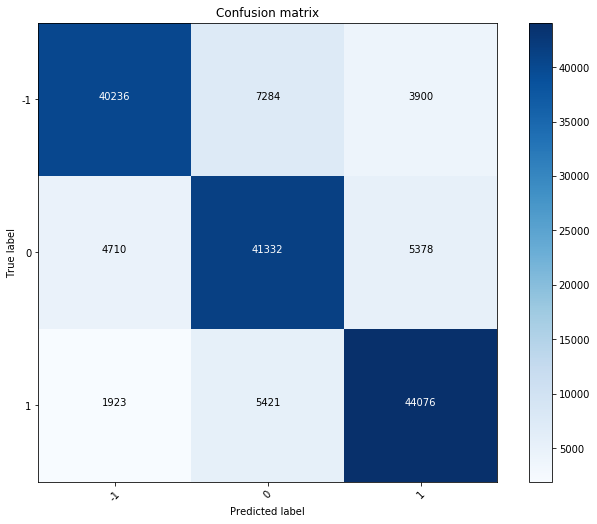

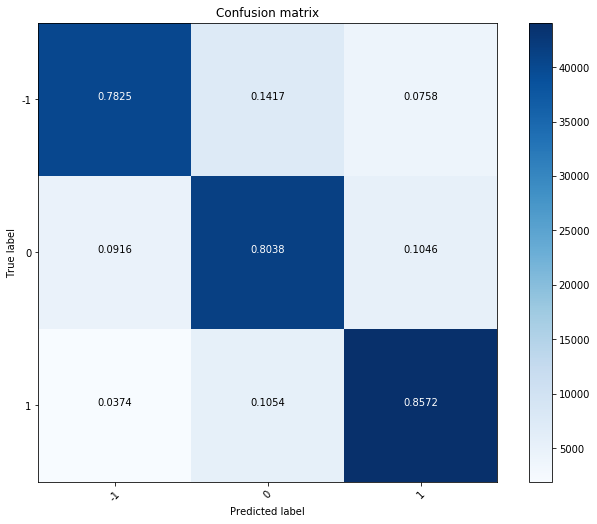

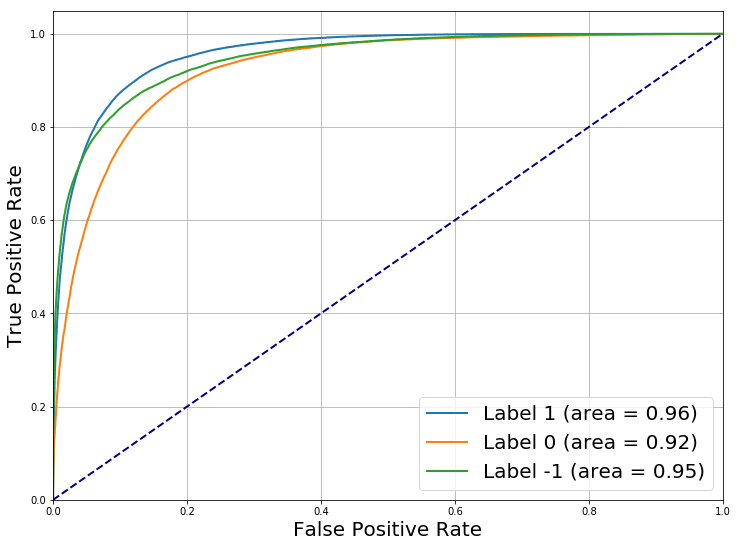

In [9]:
evaluator = MLEvaluator()
evaluator.set_pred_df(pred_df_train)
cf_mx_train = evaluator.generate_confusion_matrix()

fig = evaluator.plot_confusion_matrix(cf_mx_train.values, [-1, 0, 1])
fig = evaluator.plot_confusion_matrix(cf_mx_train.values, [-1, 0, 1], normalize=True)
fig = evaluator.plot_roc()

### Results on testing data

Confusion matrix, without normalization
[[10177  4527  1390]
 [ 6512 55263  9935]
 [ 1974  3005  8978]]
Normalized confusion matrix
[[0.63234746 0.28128495 0.08636759]
 [0.09081021 0.77064566 0.13854414]
 [0.14143441 0.21530415 0.64326145]]


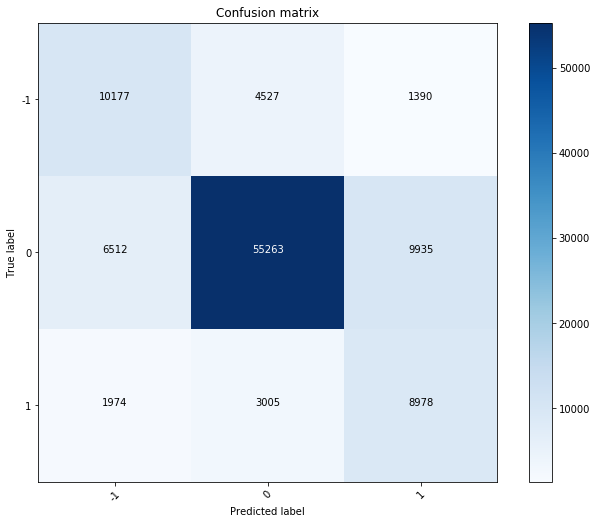

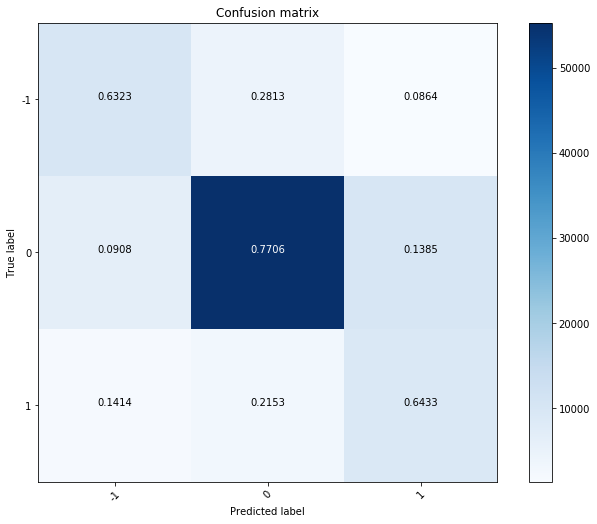

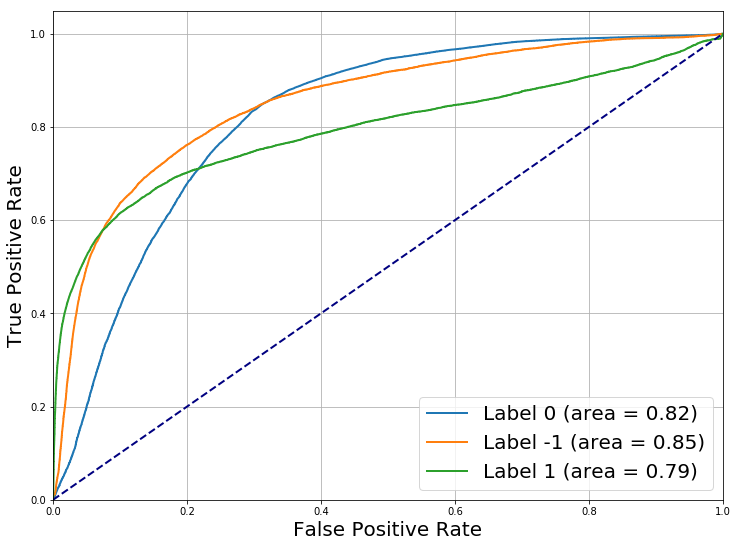

In [10]:
evaluator.set_pred_df(pred_df_test)
cf_mx_test = evaluator.generate_confusion_matrix()

fig = evaluator.plot_confusion_matrix(cf_mx_test.values, [-1, 0, 1])
fig = evaluator.plot_confusion_matrix(cf_mx_test.values, [-1, 0, 1], normalize=True)
fig = evaluator.plot_roc()